In [238]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib notebook

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# Часть 1

1. Пусть G - событие, сосотоящее в том, что подсудимый виновен, а В - событие, сосотоящее в том, что группа крови принадлежит редкой группе.
Прокурор оценил вероятность $p(B|\overline{G}) = 0.01$, откуда не следует, что $p(G|B) = 0.99$. Отсюда можно лишь сделать вывод, что $p(\overline{B}|\overline{G}) = 0.99$.

2. Для определения вероятности виновности необходимо оценить:

$$p(G|B) = \frac{p(B|G)p(G)}{p(B)} = \frac{p(B|G)p(G)}{p(B|G)p(G) + p(B|\overline{G})p(\overline{G})} $$
Мы знаем, что найденная кровь принадлежит убийце, соответственно $p(B|G) = 1$. Также прокурор уже оценил $p(B|\overline{G}) = 0.01$. Остаётся оценить априорные вероятности $p(G)$ и $p(\overline{G})$. Вместо этого адвокат оценил априорную вероятность $p(G|B)$.

3. Обозначим за x вероятность false negatives, а за y - вероятность false positives.
$$p1 = p(d=1|t=1) = \frac{p(t=1|d=1)p(d=1)}{p(t=1|d=1)p(d=1) + p(t=1|d=0)p(d=0)} = \frac{(1 - x)p(d=1)}{(1 - x)p(d=1) + yp(d=0)} = \frac{0.01(1 - x)}{0.01(1 - x) + 0.99y}$$
$$p2 = p(d=1|t=0) = \frac{p(t=0|d=1)p(d=1)}{p(t=0|d=1)p(d=1) + p(t=0|d=0)p(d=0)} = \frac{0.01x}{0.01x + 0.99(1-y)}$$
Построим графики:

<IPython.core.display.Javascript object>


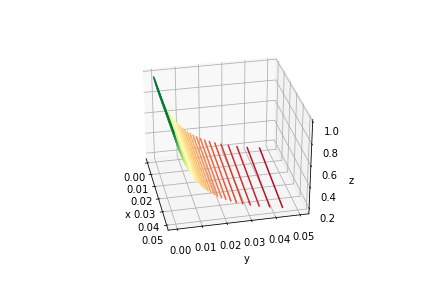

In [8]:
def get_p1(x, y):
    return 0.01*(1 - x) / (0.01 * (1 - x) + 0.99 * y)

def get_p2(x, y):
    return 0.01 * x / (0.01 * x + 0.99 * (1 - y))

x = np.linspace(0, 0.05, 500)
y = np.linspace(0, 0.05, 500)
X, Y = np.meshgrid(x, y)
p1 = get_p1(X, Y)
p2 = get_p2(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, p1, 50, cmap='RdYlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

<IPython.core.display.Javascript object>


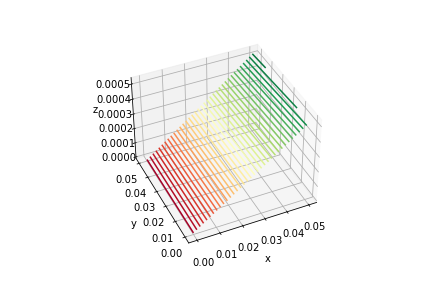

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, p2, 50, cmap='RdYlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Для медицинского теста гораздо важнее снизить вероятность $p(d=1|t=0)$, чем повысить вероятность $p(d=1|t=1)$, а $p(d=1|t=0)$ растёт быстрее по x, чем по y. Таким образом, более правильным решением будет уменьшать число false negatives.

# Часть 2

## Задание 1

In [295]:
data = pd.read_csv('owid-covid-data.csv')

In [296]:
data_russia = data[data['location'] == 'Russia']

In [297]:
start_date = datetime.strptime('2020-03-02', '%Y-%m-%d')

In [298]:
start_date

datetime.datetime(2020, 3, 2, 0, 0)

In [299]:
data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)

<ipython-input-299-0f16b0453dc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)


In [300]:
data_russia = data_russia[data_russia['days'] > 0]

In [301]:
data_russia['new_cases'] = data_russia['new_cases'].transform(lambda x: 1 if x == 0 else x)

In [302]:
train_data_russia = data_russia[data_russia['days'] <= 50]
test_data_russia = data_russia[data_russia['days'] > 50]

## Задание 2

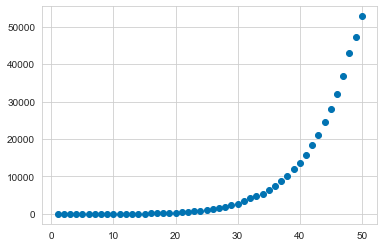

In [303]:
%matplotlib inline
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

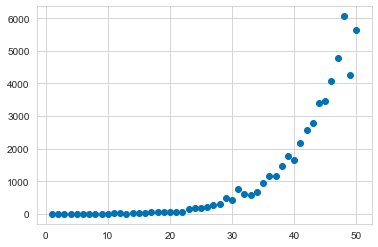

In [304]:
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy())
plt.show()

### 2.a

Для обучения модели в предположении экспоненциальности роста числа заболевших прологарифмируем целевые переменные

In [306]:
train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))
train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))

<ipython-input-306-d6ab12559a3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))
<ipython-input-306-d6ab12559a3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))


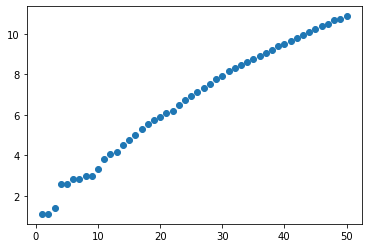

In [62]:
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

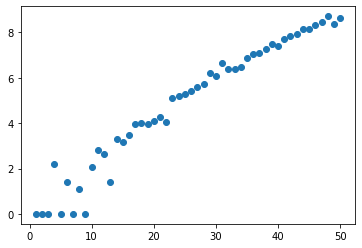

In [60]:
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy())
plt.show()

Как мы видим после логарифмирования зависимости целевых переменных от дней стали квазилинейными. Таким образом, можно попытаться обучить линейную модель.

In [244]:
exp_model = LinearRegression()
exp_model.fit(train_data_russia['days'].to_numpy().reshape(-1, 1), train_data_russia['total_cases'])

LinearRegression()

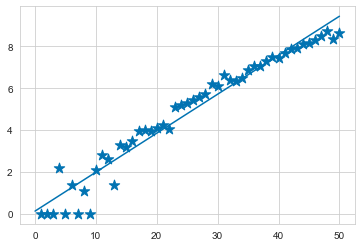

In [245]:
def predicted_curve(x):
    return x * exp_model.coef_ + exp_model.intercept_

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([0] + list(train_data_russia['days'].to_numpy()), predicted_curve([0] + list(train_data_russia['days'].to_numpy())))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 2.b

Оценим дисперсию шума в данных исходя из параметров полученной модели:

In [271]:
def get_disp(X, Y, w0, w1):
    return np.sum((Y - w0 - X * w1)**2) / len(X)

In [272]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), exp_model.intercept_, exp_model.coef_)

In [273]:
sigma = math.sqrt(disp)

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [274]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [275]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [276]:
def plot_w_space_heatmap(X, Y, sigma, w0_lim=[-1, 1], w1_lim=[-1, 1]):
    w0 = np.linspace(w0_lim[0], w0_lim[1], 1000)
    w1 = np.linspace(w1_lim[0], w1_lim[1], 1000)
    w0, w1 = np.meshgrid(w0, w1)
    pos = np.empty(w0.shape + (2,))
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1
    plt.xlim((w0_lim[0], w0_lim[1]))
    plt.ylim((w1_lim[0], w1_lim[1]))
    p = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    plt.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


In [277]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma)

<ipython-input-276-0d8cdc2cc10b>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


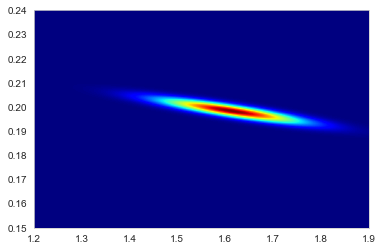

In [278]:
plot_w_space_heatmap(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma, [1.2, 1.9], [0.15, 0.24])

### 2.c

In [279]:
def plot_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60), math.exp(w[0] + w[1]*91), math.exp(w[0] + w[1]*183))
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)

In [281]:
def plot_new_cases_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs) - np.exp(w[0] + w[1]*(xs - 1)), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60) - math.exp(w[0] + w[1]*59),
              math.exp(w[0] + w[1]*91) - math.exp(w[0] + w[1]*90),
              math.exp(w[0] + w[1]*183) - math.exp(w[0] + w[1]*182))
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)

822623.8326634957 407549218.69042015 4.056781319430718e+16
682993.7853582312 303680320.29293245 2.1927897258493652e+16
829001.8608920773 445759164.959269 5.657864194553114e+16
646393.1661318935 281814281.21177447 1.9196305341211024e+16
562454.1656736208 207297993.23124927 8576861543740335.0
875012.1432799915 485546485.5484048 6.766403603135761e+16
931856.3189190534 527635423.1465493 7.806977847279325e+16
763088.604760452 376564788.12458545 3.704711705229742e+16
755538.6369313749 361749213.4840666 3.2538974837188556e+16
846068.2028123516 418682114.50949395 4.153391178549848e+16
720648.890139625 306863375.1703901 1.948926550992667e+16
813088.4807920391 389746565.82541573 3.5175749574622684e+16
685258.8084693633 310025746.2392292 2.3570266016909436e+16
819521.308454234 413171191.1396926 4.331713332601124e+16
794477.9408581185 402198209.2475744 4.268523103930223e+16
777377.60077544 373859273.162955 3.4073596476581588e+16
934959.8678767913 559687419.267005 9.76827108832496e+16
761447.530228

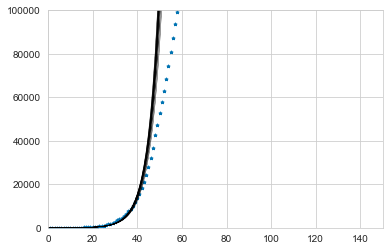

In [282]:
plot_sample_exponents(sigma, 20, xlim=(0, 150), ylim=(0, 100000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

Полученная модель предсказывает более 60000 случаев заражения к 1 мая, более 200000000 к 1 июня и более 10^16 к 1 сентября, что, как мы видим, на деле оказалось не так. С новыми случаями заражения ситуация идентичная:

181156.22298245563 104224458.43334025 1.6169226911257368e+16
167438.67699889233 94117823.29130346 1.3627506618999488e+16
113934.13358583488 49615652.48300138 3368103024719522.0
120726.98682470038 51138608.98245093 3197734567198932.0
114502.90918991237 48350435.16598359 2995406253013674.0
150113.90748027316 80513516.51583153 1.014298274172348e+16
126769.33977920224 56503600.70667055 4109681845083880.0
132430.81553041714 57500738.80126047 3869367200580316.0
154565.17251438228 78098211.48285049 8241737857736656.0
136229.70628290996 61873575.696711004 4758698524952308.0
141676.91988174815 67816886.18856215 6095385799955636.0
173563.192355874 93103840.34577203 1.173407293556888e+16
141290.58710009395 67611887.12674081 6071609582643816.0
118056.06902266585 56499266.089505285 5075234652863880.0
120530.04823527706 50364985.58574656 3024679764838594.0
106988.72615359433 43373083.648187876 2380904162098002.0
150485.663183799 70963585.88976002 6101176550494752.0
142087.04484589456 69536881.794635

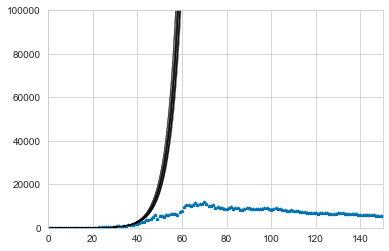

In [283]:
plot_new_cases_sample_exponents(sigma, 20, xlim=(0, 150), ylim=(0, 100000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения

In [284]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [291]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] - sigma), np.exp(mu[1]*days_arr + mu[0] + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

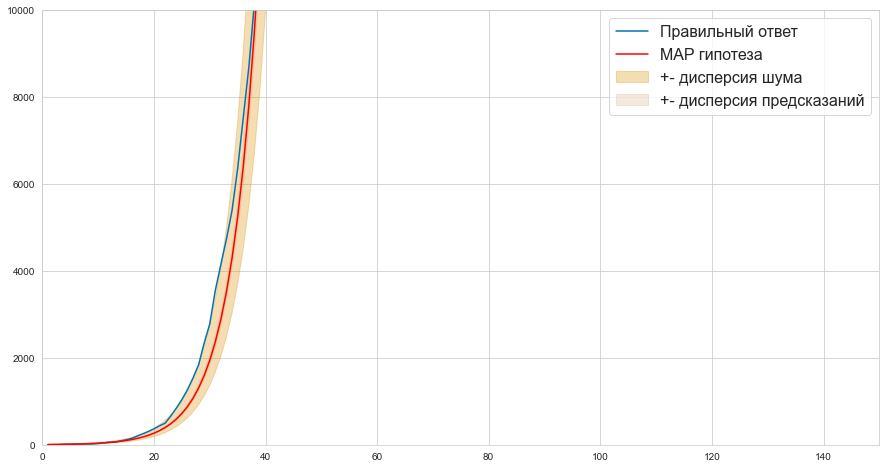

In [292]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred)

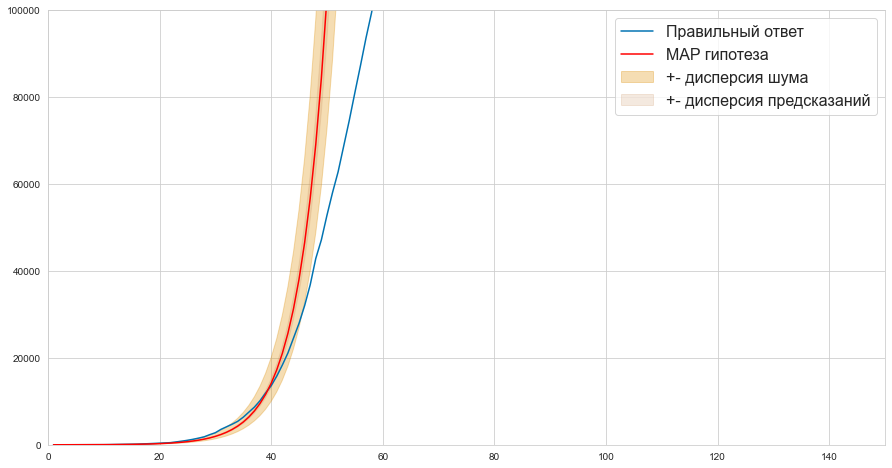

In [287]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 150), ylim=(0, 100000))

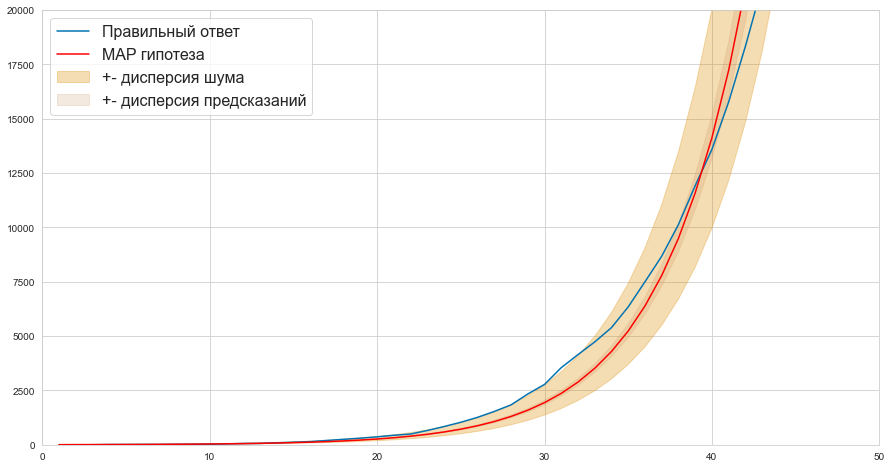

In [288]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 50), ylim=(0, 20000))

## Задание 3

### 3.a

Возьмем производную от Ф(x) ("физический смысл" - скорость прироста случаев) и в качестве целевой переменной возьмём new_cases. Тогда $ln(y) \propto w_0 + w_1 x + w_2 x^2$

In [333]:
train_data_new = pd.DataFrame()
train_data_new['days'] = train_data_russia['days']
train_data_new['days_2'] = train_data_new['days']**2

In [334]:
probit_model = LinearRegression()
probit_model.fit(train_data_new, train_data_russia['new_cases'])

LinearRegression()

In [335]:
probit_model.coef_

array([ 0.27928241, -0.00182979])

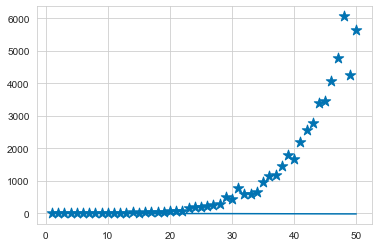

In [352]:
def predicted_curve(x):
    return exp_model.intercept_ + x * exp_model.coef_[0] + x**2 * exp_model.coef_[1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_data_russia['days'].to_numpy(), predicted_curve(train_data_russia['days'].to_numpy()))
ax.scatter(train_data_russia['days'].to_numpy(), np.exp(train_data_russia['new_cases'].to_numpy()), marker='*', s=120)
plt.show()

### 3.b

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [337]:
def get_disp(X, Y, w0, w1, w2):
    return np.sum((Y - w0 - X * w1 - X**2 * w2)**2) / len(X)

In [338]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), exp_model.intercept_, exp_model.coef_[0], exp_model.coef_[1])

In [339]:
sigma = math.sqrt(disp)

In [341]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [405]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[5, 0, 0], [0, 5, 0], [0, 0, 5]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [406]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), sigma)

### 3.c

In [445]:
def plot_sample_sigmoids(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    cases_num = [[], [], []]
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2)), 'k-', lw=.4)
        cases_num[0].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[60])
        cases_num[1].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[91])
        cases_num[2].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[183])
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)
    return cases_num

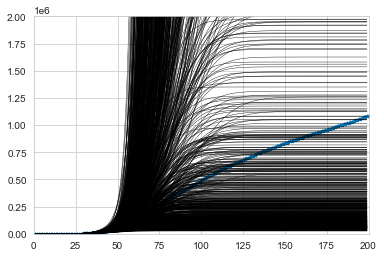

In [446]:
cases_num = plot_sample_sigmoids(sigma, 1000, xlim=(0, 200), ylim=(0, 2000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

In [447]:
for i in range(3):
    print(np.percentile(cases_num[i], 10), np.percentile(cases_num[i], 90))

55291.04162176546 607053.2191715057
72604.66363252027 208494312.66185054
72651.59927877456 2.7721797107805856e+16


Из полученных результатов можно сделать вывод, что в оптимистичном сценарии в России будет порядка 72000 случаев, в пессимистичном сценарии переболеют все.

In [409]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2]*xs**2
    return res

In [410]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2)), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma)), np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma)), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.cumsum(np.mean(np.exp(predictions), axis=0)) - np.cumsum(np.std(np.exp(predictions), axis=0)), np.cumsum(np.mean(np.exp(predictions), axis=0)) + np.cumsum(np.std(np.exp(predictions), axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

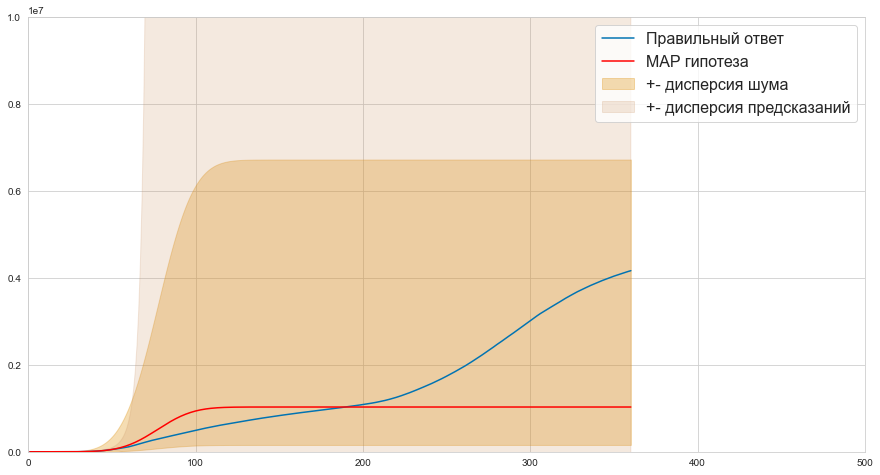

In [411]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 500), ylim=(0, 10000000))